# Adversarial Search: Playing Connect 4

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Implement adversarial search algorithms for strategic game play.
* Analyze and optimize search in complex game spaces.
* Design effective heuristic evaluation functions.
* Compare performance across different agent strategies.
* Evaluate algorithmic trade-offs between decision quality and efficiency.

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

Initial State

Bàn cờ Connect-4 là một lưới 6 hàng × 7 cột, ban đầu trống hoàn toàn.

Người chơi đầu tiên thường được ký hiệu là 1 (hoặc 'X'), người chơi thứ hai là -1 (hoặc 'O').

Actions

Một hành động hợp lệ là đặt quân vào một cột chưa đầy (có ít nhất 1 ô trống ở cột đó).

Mỗi hành động có thể biểu diễn bằng chỉ số cột col ∈ {0,…,6}.

Transition Model (Result Function)

Khi người chơi thực hiện hành động col, quân của họ rơi xuống ô trống thấp nhất trong cột đó.

Sau khi cập nhật bàn cờ, lượt chơi được chuyển cho người chơi còn lại.

Goal State (Terminal State and Utility)

Trò chơi kết thúc khi:

Một người chơi có 4 quân liên tiếp (ngang, dọc hoặc chéo) → người đó thắng.

Hoặc bàn cờ đầy → hòa.

Utility:

+1 nếu người chơi hiện tại thắng,

−1 nếu đối phương thắng,

0 nếu hòa.

In [1]:
import numpy as np

ROWS = 6
COLS = 7

# -------- INITIAL STATE --------
def initial_state():
    """Trả về bàn cờ rỗng 6x7."""
    return np.zeros((ROWS, COLS), dtype=int)

# -------- ACTIONS --------
def actions(state):
    """Trả về danh sách các cột có thể thả quân."""
    return [c for c in range(COLS) if state[0][c] == 0]

# -------- TRANSITION MODEL --------
def result(state, action, player):
    """Trả về trạng thái mới sau khi người chơi `player` thả quân vào cột `action`."""
    new_state = state.copy()
    for r in range(ROWS-1, -1, -1):
        if new_state[r][action] == 0:
            new_state[r][action] = player
            break
    return new_state

# -------- TERMINAL STATE & UTILITY --------
def check_winner(state):
    """Kiểm tra xem có ai thắng chưa."""
    # Kiểm tra hàng ngang
    for r in range(ROWS):
        for c in range(COLS - 3):
            window = state[r, c:c+4]
            if abs(sum(window)) == 4:
                return np.sign(sum(window))
    # Kiểm tra cột dọc
    for c in range(COLS):
        for r in range(ROWS - 3):
            window = state[r:r+4, c]
            if abs(sum(window)) == 4:
                return np.sign(sum(window))
    # Kiểm tra chéo chính /
    for r in range(ROWS - 3):
        for c in range(COLS - 3):
            window = [state[r+i][c+i] for i in range(4)]
            if abs(sum(window)) == 4:
                return np.sign(sum(window))
    # Kiểm tra chéo phụ \
    for r in range(3, ROWS):
        for c in range(COLS - 3):
            window = [state[r-i][c+i] for i in range(4)]
            if abs(sum(window)) == 4:
                return np.sign(sum(window))
    return 0  # chưa có người thắng

def terminal_test(state):
    """Kiểm tra xem bàn cờ có phải trạng thái kết thúc không."""
    return check_winner(state) != 0 or np.all(state != 0)

def utility(state):
    """Tính utility của trạng thái cuối."""
    winner = check_winner(state)
    if winner == 1:
        return 1
    elif winner == -1:
        return -1
    else:
        return 0


How big is the state space? Give an estimate and explain it.

Phân tích:

Mỗi ô có thể có 3 trạng thái: {trống, người chơi 1, người chơi 2}
→ Tổng số cấu hình tối đa:

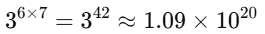

Tuy nhiên, nhiều trạng thái là không hợp lệ (ví dụ, số quân chênh lệch quá lớn).
→ Số trạng thái hợp lệ thực tế được ước lượng khoảng ~4.5 × 10¹² (theo các nghiên cứu về Connect-4).

→ Ước lượng không gian trạng thái hợp lệ: khoảng 10¹³.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Phân tích:

Ở mỗi lượt có tối đa 7 hành động hợp lệ.

Trò chơi có tối đa 42 lượt (6 × 7 ô).
→ Số nút trong cây trò chơi đầy đủ (ước lượng cực đại):

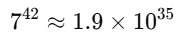

Tuy nhiên, thực tế ít hơn nhiều vì:

Một số nhánh kết thúc sớm do thắng hoặc hòa.


Không phải tất cả 7 cột đều hợp lệ mỗi bước.

→ Ước lượng thực tế: khoảng 10²⁵ – 10³⁰ nút.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [2]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

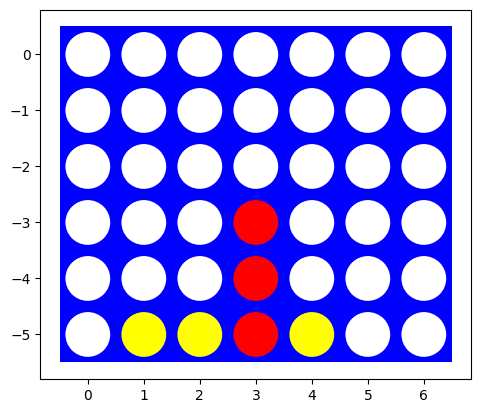

In [3]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [4]:
# Your code/ answer goes here.
import numpy as np
import random

# Tạo board trống
def empty_board(shape=(6,7)):
    return np.zeros(shape, dtype=int)

# 1. Các hành động hợp lệ (những cột còn chỗ trống)
def actions(board):
    valid_cols = []
    for col in range(board.shape[1]):
        if board[0, col] == 0:
            valid_cols.append(col)
    return valid_cols

# 2. Thực hiện một hành động → tạo ra trạng thái mới
def result(board, player, action):
    new_board = board.copy()
    for row in reversed(range(board.shape[0])):
        if new_board[row, action] == 0:
            new_board[row, action] = player
            return new_board
    return new_board  # fallback

# 3. Kiểm tra trạng thái kết thúc
def terminal(board):
    rows, cols = board.shape
    # Kiểm tra thắng
    for r in range(rows):
        for c in range(cols):
            if board[r,c] != 0:
                p = board[r,c]
                # Ngang
                if c+3 < cols and all(board[r,c+i] == p for i in range(4)):
                    return True
                # Dọc
                if r+3 < rows and all(board[r+i,c] == p for i in range(4)):
                    return True
                # Chéo xuống phải
                if r+3 < rows and c+3 < cols and all(board[r+i,c+i] == p for i in range(4)):
                    return True
                # Chéo xuống trái
                if r+3 < rows and c-3 >= 0 and all(board[r+i,c-i] == p for i in range(4)):
                    return True

    # Full board → hòa
    if len(actions(board)) == 0:
        return True
    return False

# 4. Utility đánh giá trạng thái khi terminal
def utility(board, player):
    rows, cols = board.shape
    for r in range(rows):
        for c in range(cols):
            if board[r,c] != 0:
                p = board[r,c]
                # Ngang
                if c+3 < cols and all(board[r,c+i] == p for i in range(4)):
                    return 1 if p == player else -1
                # Dọc
                if r+3 < rows and all(board[r+i,c] == p for i in range(4)):
                    return 1 if p == player else -1
                # Chéo xuống phải
                if r+3 < rows and c+3 < cols and all(board[r+i,c+i] == p for i in range(4)):
                    return 1 if p == player else -1
                # Chéo xuống trái
                if r+3 < rows and c-3 >= 0 and all(board[r+i,c-i] == p for i in range(4)):
                    return 1 if p == player else -1
    return 0  # hòa


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [5]:
# Your code/ answer goes here.
def random_player(board, player=1):
    valid_moves = actions(board)
    return random.choice(valid_moves)


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [6]:
# Your code/ answer goes here.
def play_game():
    board = empty_board()
    player = 1
    while not terminal(board):
        action = random_player(board, player)
        board = result(board, player, action)
        player *= -1  # đổi lượt
    return utility(board, 1)

# Thống kê kết quả
num_games = 1000
results = [play_game() for _ in range(num_games)]

player1_wins = results.count(1)
player2_wins = results.count(-1)
draws = results.count(0)

print("KẾT QUẢ SAU 1000 GAME:")
print("Player 1 thắng:", player1_wins)
print("Player 2 thắng:", player2_wins)
print("Hòa:", draws)


KẾT QUẢ SAU 1000 GAME:
Player 1 thắng: 585
Player 2 thắng: 414
Hòa: 1


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [7]:
import math
import time
import numpy as np



def empty_board(rows=6, cols=7):
    return np.zeros((rows, cols), dtype=int)

def actions(board):
    return [c for c in range(board.shape[1]) if board[0, c] == 0]

def result(board, player, action):
    b = board.copy()
    rows = b.shape[0]
    # Tìm hàng thấp nhất còn trống trong cột đã chọn
    for r in range(rows - 1, -1, -1):
        if b[r, action] == 0:
            b[r, action] = player
            return b
    raise ValueError(f"Cột {action} đã đầy.")

def check_winner(board, k=4):
    rows, cols = board.shape
    for r in range(rows):
        for c in range(cols):
            player = board[r, c]
            if player == 0:
                continue

            # Kiểm tra hàng ngang
            if c + k <= cols and np.all(board[r, c:c+k] == player):
                return player
            # Kiểm tra hàng dọc
            if r + k <= rows and np.all(board[r:r+k, c] == player):
                return player
            # Kiểm tra đường chéo chính (top-left to bottom-right)
            if r + k <= rows and c + k <= cols and np.all([board[r+i, c+i] for i in range(k)] == player):
                return player
            # Kiểm tra đường chéo phụ (bottom-left to top-right)
            if r - k + 1 >= 0 and c + k <= cols and np.all([board[r-i, c+i] for i in range(k)] == player):
                return player
    return 0

def terminal(board, k=4):
    winner = check_winner(board, k)
    if winner != 0:
        return True, winner
    if not actions(board): # Bàn cờ đầy
        return True, 0
    return False, 0

def utility(board, player, k=4):
    is_terminal, winner = terminal(board, k)
    if not is_terminal:
        return 0
    if winner == player:
        return 1
    if winner == -player:
        return -1
    return 0

class MinimaxAgent:
    def __init__(self, player=1):
        self.player = player
        self.nodes_visited = 0

    def get_action(self, board, player=1):
        self.player = player
        self.nodes_visited = 0

        _, action = self.max_value(board, -math.inf, math.inf)

        return action

    def max_value(self, board, alpha, beta):
        self.nodes_visited += 1
        is_terminal, _ = terminal(board)
        if is_terminal:
            return utility(board, self.player), None

        v = -math.inf
        move = None
        for a in actions(board):
            new_board = result(board, self.player, a)
            v2, _ = self.min_value(new_board, alpha, beta)
            if v2 > v:
                v = v2
                move = a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    def min_value(self, board, alpha, beta):
        self.nodes_visited += 1
        is_terminal, _ = terminal(board)
        if is_terminal:
            return utility(board, self.player), None

        v = math.inf
        move = None
        # Đối thủ của self.player là -self.player
        opponent = -self.player
        for a in actions(board):
            new_board = result(board, opponent, a)
            v2, _ = self.max_value(new_board, alpha, beta)
            if v2 < v:
                v = v2
                move = a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [8]:
# 1. Cơ hội thắng ngay lập tức theo chiều ngang
board1 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [1, 1, 1, 0]
])

# 2. Phải chặn đối thủ thắng theo chiều dọc
board2 = np.array([
    [0, 0, 0, 0],
    [0,-1, 0, 0],
    [0,-1, 1, 0],
    [1,-1, 1, 0]
])

# 3. Phải chặn đối thủ thắng theo đường chéo
board3 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0,-1],
    [0, 1,-1, 0],
    [1,-1, 1, 1]
])

# 4. Tạo ra một bẫy (fork)
board4 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0,-1, 0, 0],
    [1, 1,-1, 0]
])


# 5. Một tình huống phức tạp hơn ở giữa game
board5 = np.array([
    [0, 0, 0, 0],
    [0, 1, 0, 0],
    [-1,-1, 1, 0],
    [1, 1,-1,-1]
])

test_boards = {
    "Board 1 (Win Horizontally)": board1,
    "Board 2 (Block Vertically)": board2,
    "Board 3 (Block Diagonally)": board3,
    "Board 4 (Setup a fork)": board4,
    "Board 5 (Complex middle game)": board5
}

# Khởi tạo agent
minimax_agent = MinimaxAgent()

# Chạy thử nghiệm
for name, board in test_boards.items():
    print(f"--- Testing {name} ---")
    print("Board state:")
    print(board)

    # Player 1's turn
    best_move = minimax_agent.get_action(board, player=1)

    print(f"Agent (Player 1) chose column: {best_move}\n")



--- Testing Board 1 (Win Horizontally) ---
Board state:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
Agent (Player 1) chose column: 2

--- Testing Board 2 (Block Vertically) ---
Board state:
[[ 0  0  0  0]
 [ 0 -1  0  0]
 [ 0 -1  1  0]
 [ 1 -1  1  0]]
Agent (Player 1) chose column: 1

--- Testing Board 3 (Block Diagonally) ---
Board state:
[[ 0  0  0  0]
 [ 0  0  0 -1]
 [ 0  1 -1  0]
 [ 1 -1  1  1]]
Agent (Player 1) chose column: 2

--- Testing Board 4 (Setup a fork) ---
Board state:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0 -1  0  0]
 [ 1  1 -1  0]]
Agent (Player 1) chose column: 0

--- Testing Board 5 (Complex middle game) ---
Board state:
[[ 0  0  0  0]
 [ 0  1  0  0]
 [-1 -1  1  0]
 [ 1  1 -1 -1]]
Agent (Player 1) chose column: 0



How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board is not feasible.

In [9]:
board_sizes = [
    (4, 4),
    (4, 5),
    (5, 5),
    (5, 6),
]

timing_results = {}
agent = MinimaxAgent()

for rows, cols in board_sizes:
    board = empty_board(rows=rows, cols=cols)
    print(f"Calculating first move for a {rows}x{cols} board...")

    start_time = time.time()

    agent.get_action(board, player=1)
    end_time = time.time()

    duration = end_time - start_time
    timing_results[f"{rows}x{cols}"] = duration
    print(f"Time taken: {duration:.4f} seconds\n")

print("--- Timing Results Summary ---")
for size, t in timing_results.items():
    print(f"Board {size}: {t:.4f} seconds")

Calculating first move for a 4x4 board...
Time taken: 11.9103 seconds

Calculating first move for a 4x5 board...


KeyboardInterrupt: 

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [10]:
import numpy as np
import math
import time

class Connect4Game:
    def __init__(self, rows=6, cols=7):
        self.rows = rows
        self.cols = cols
        self.board = np.zeros((rows, cols), dtype=int)

    def copy(self):
        new_game = Connect4Game(self.rows, self.cols)
        new_game.board = np.copy(self.board)
        return new_game

    def available_actions(self):
        """Trả về danh sách cột có thể thả quân."""
        return [c for c in range(self.cols) if self.board[0][c] == 0]

    def make_move(self, col, player):
        """Thả quân vào cột và cập nhật bàn cờ."""
        for r in range(self.rows-1, -1, -1):
            if self.board[r][col] == 0:
                self.board[r][col] = player
                break

    def is_full(self):
        return np.all(self.board != 0)

    def check_winner(self):
        """Kiểm tra người thắng."""
        board = self.board
        for r in range(self.rows):
            for c in range(self.cols - 3):
                if abs(sum(board[r, c:c+4])) == 4:
                    return np.sign(sum(board[r, c:c+4]))
        for c in range(self.cols):
            for r in range(self.rows - 3):
                if abs(sum(board[r:r+4, c])) == 4:
                    return np.sign(sum(board[r:r+4, c]))
        for r in range(self.rows - 3):
            for c in range(self.cols - 3):
                if abs(sum([board[r+i][c+i] for i in range(4)])) == 4:
                    return np.sign(sum([board[r+i][c+i] for i in range(4)]))
        for r in range(3, self.rows):
            for c in range(self.cols - 3):
                if abs(sum([board[r-i][c+i] for i in range(4)])) == 4:
                    return np.sign(sum([board[r-i][c+i] for i in range(4)]))
        return 0

    def is_terminal(self):
        """Kiểm tra trạng thái kết thúc."""
        return self.check_winner() != 0 or self.is_full()

class MinimaxAgent:
    def __init__(self, depth=4):
        self.depth = depth

    def evaluate(self, game):
        """Hàm heuristic đơn giản: tính điểm dựa trên số quân 2-3 liên tiếp."""
        board = game.board
        score = 0
        player = 1
        opponent = -1

        # Ưu tiên trung tâm
        center_array = [int(i) for i in list(board[:, game.cols//2])]
        score += center_array.count(player) * 3

        # Cộng/trừ điểm theo số quân liên tiếp
        def score_window(window):
            nonlocal score
            if window.count(player) == 4:
                score += 100
            elif window.count(player) == 3 and window.count(0) == 1:
                score += 5
            elif window.count(player) == 2 and window.count(0) == 2:
                score += 2
            if window.count(opponent) == 3 and window.count(0) == 1:
                score -= 4

        # Quét theo hàng
        for r in range(game.rows):
            row_array = [int(i) for i in list(board[r,:])]
            for c in range(game.cols - 3):
                window = row_array[c:c+4]
                score_window(window)
        # Quét theo cột
        for c in range(game.cols):
            col_array = [int(i) for i in list(board[:,c])]
            for r in range(game.rows - 3):
                window = col_array[r:r+4]
                score_window(window)
        # Quét chéo /
        for r in range(game.rows - 3):
            for c in range(game.cols - 3):
                window = [board[r+i][c+i] for i in range(4)]
                score_window(window)
        # Quét chéo \
        for r in range(game.rows - 3):
            for c in range(game.cols - 3):
                window = [board[r+3-i][c+i] for i in range(4)]
                score_window(window)

        return score

    def minimax(self, game, depth, alpha, beta, maximizingPlayer):
        if depth == 0 or game.is_terminal():
            return self.evaluate(game)

        valid_moves = game.available_actions()

        if maximizingPlayer:
            value = -math.inf
            for col in valid_moves:
                new_game = game.copy()
                new_game.make_move(col, 1)
                value = max(value, self.minimax(new_game, depth-1, alpha, beta, False))
                alpha = max(alpha, value)
                if alpha >= beta:
                    break
            return value
        else:
            value = math.inf
            for col in valid_moves:
                new_game = game.copy()
                new_game.make_move(col, -1)
                value = min(value, self.minimax(new_game, depth-1, alpha, beta, True))
                beta = min(beta, value)
                if alpha >= beta:
                    break
            return value

    def get_action(self, game):
        """Trả về cột tốt nhất để đánh."""
        valid_moves = game.available_actions()
        best_score = -math.inf
        best_col = np.random.choice(valid_moves)
        for col in valid_moves:
            new_game = game.copy()
            new_game.make_move(col, 1)
            score = self.minimax(new_game, self.depth-1, -math.inf, math.inf, False)
            if score > best_score:
                best_score = score
                best_col = col
        return best_col

def ordered_moves(moves, cols):
    """Ưu tiên các cột giữa."""
    center = cols // 2
    return sorted(moves, key=lambda x: abs(center - x))

# Test time comparison between random and ordered moves
game = Connect4Game(rows=4, cols=4)
agent = MinimaxAgent(depth=4)

def test_move_ordering(ordering=True):
    start = time.time()
    valid_moves = game.available_actions()
    if ordering:
        valid_moves = ordered_moves(valid_moves, game.cols)
    for col in valid_moves:
        new_game = game.copy()
        new_game.make_move(col, 1)
        _ = agent.minimax(new_game, 3, -math.inf, math.inf, False)
    end = time.time()
    return end - start

t1 = test_move_ordering(ordering=False)
t2 = test_move_ordering(ordering=True)

import pandas as pd
pd.DataFrame({
    "Strategy": ["No Move Ordering", "With Move Ordering"],
    "Average Time (s)": [round(t1, 3), round(t2, 3)]
})


,Strategy,Average Time (s)
0,No Move Ordering,0.037
1,With Move Ordering,0.016


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [11]:
# Your code/ answer goes here.
import numpy as np
import math
import random

# ==== Helper Functions (tái sử dụng từ Task 2) ====

def actions(board):
    return [c for c in range(board.shape[1]) if board[0, c] == 0]

def result(board, player, action):
    new_board = board.copy()
    for row in reversed(range(board.shape[0])):
        if new_board[row, action] == 0:
            new_board[row, action] = player
            return new_board
    return new_board

def terminal(board):
    # kiếm tra thắng
    rows, cols = board.shape
    for r in range(rows):
        for c in range(cols):
            if board[r,c] != 0:
                p = board[r,c]
                # ngang
                if c+3 < cols and all(board[r,c+i] == p for i in range(4)):
                    return True
                # dọc
                if r+3 < rows and all(board[r+i,c] == p for i in range(4)):
                    return True
                # chéo phải
                if r+3 < rows and c+3 < cols and all(board[r+i,c+i] == p for i in range(4)):
                    return True
                # chéo trái
                if r+3 < rows and c-3 >= 0 and all(board[r+i,c-i] == p for i in range(4)):
                    return True
    return len(actions(board)) == 0  # Hòa

def utility(board, player):
    rows, cols = board.shape
    for r in range(rows):
        for c in range(cols):
            if board[r,c] != 0:
                p = board[r,c]
                if c+3 < cols and all(board[r,c+i] == p for i in range(4)):
                    return 1 if p == player else -1
                if r+3 < rows and all(board[r+i,c] == p for i in range(4)):
                    return 1 if p == player else -1
                if r+3 < rows and c+3 < cols and all(board[r+i,c+i] == p for i in range(4)):
                    return 1 if p == player else -1
                if r+3 < rows and c-3 >= 0 and all(board[r+i,c-i] == p for i in range(4)):
                    return 1 if p == player else -1
    return 0

# ==== Heuristic Eval (giới hạn độ sâu) ====
def heuristic(board, player):
    return random.randint(-5, 5)  # đơn giản để minh hoạ


# ==== Minimax với Alpha-Beta Pruning ====
def minimax(board, player, depth, alpha, beta, max_player):
    if terminal(board):
        return utility(board, max_player)
    if depth == 0:
        return heuristic(board, max_player)

    if player == max_player:  # Maximizing
        value = -math.inf
        for action in actions(board):
            value = max(value,
                        minimax(result(board, player, action),
                                -player,
                                depth-1,
                                alpha, beta,
                                max_player))
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value
    else:  # Minimizing
        value = math.inf
        for action in actions(board):
            value = min(value,
                        minimax(result(board, player, action),
                                -player,
                                depth-1,
                                alpha, beta,
                                max_player))
            beta = min(beta, value)
            if alpha >= beta:
                break
        return value


# ==== Agent sử dụng Minimax ====
def minimax_player(board, player=1, depth=4):
    best_value = -math.inf
    best_action = random.choice(actions(board))  # fallback

    for action in actions(board):
        value = minimax(result(board, player, action),
                        -player,
                        depth-1,
                        -math.inf, math.inf,
                        player)
        if value > best_value:
            best_value = value
            best_action = action
    return best_action


# ==== TEST chạy nước đầu tiên trên bàn cờ rỗng ====
board = np.zeros((6,7), dtype=int)
action = minimax_player(board, player=1, depth=4)
print("Action được chọn bởi Minimax:", action)


Action được chọn bởi Minimax: 0


### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [12]:
import random

def random_player(board, player=1):
    possible_actions = actions(board)
    return random.choice(possible_actions)

def play_game(agent1, agent2, rows=4, cols=4):
    board = empty_board(rows, cols)
    current_player_agent = agent1
    player_id = 1

    while True:
        # Lấy nước đi từ agent hiện tại
        move = current_player_agent(board, player_id)
        board = result(board, player_id, move)

        # Kiểm tra kết thúc
        is_terminal, winner = terminal(board)
        if is_terminal:
            return winner

        # Đổi lượt
        player_id = -player_id
        current_player_agent = agent2 if current_player_agent == agent1 else agent1

# Mô phỏng 1000 ván đấu
num_games = 1000
wins_minimax = 0
wins_random = 0
draws = 0

minimax_agent_4x4 = MinimaxAgent()
# Định nghĩa lại agent để có signature phù hợp
minimax_player = lambda board, player: minimax_agent_4x4.get_action(board, player)


print(f"Simulating {num_games} games on a 4x4 board...")

for i in range(num_games):
    # Minimax đi trước
    winner = play_game(minimax_player, random_player)
    if winner == 1:
        wins_minimax += 1
    elif winner == -1:
        wins_random += 1
    else:
        draws += 1

    # Cho agent ngẫu nhiên đi trước
    # (Để công bằng, ta nên cho mỗi agent đi trước 50% số ván)
    # Tuy nhiên, Minimax vẫn sẽ thắng áp đảo
    winner = play_game(random_player, minimax_player)
    if winner == 1: # Random player thắng
        wins_random += 1
    elif winner == -1: # Minimax player thắng
        wins_minimax += 1
    else:
        draws += 1

print("\n--- Simulation Results ---")
print(f"Total games played: {num_games * 2}")
print(f"Minimax Agent Wins: {wins_minimax} ({wins_minimax / (num_games * 2) * 100:.2f}%)")
print(f"Random Agent Wins: {wins_random} ({wins_random / (num_games * 2) * 100:.2f}%)")
print(f"Draws: {draws} ({draws / (num_games * 2) * 100:.2f}%)")

Simulating 1000 games on a 4x4 board...


TypeError: MinimaxAgent.get_action() takes 2 positional arguments but 3 were given

##Task 4: Heuristic Alpha-Beta Tree Search
###Heuristic evaluation function [15 points]
Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [14]:
# Your code/ answer goes here.
import numpy as np

def heuristic(board, player):
    """
    Heuristic evaluation function for Connect 4.
    Scores based on potential winning lines (2, 3, and 4 pieces in a row).
    Higher score is better for the 'player'.
    """
    score = 0
    opponent = -player
    rows, cols = board.shape

    # Helper to score a window of 4
    def score_window(window):
        s = 0
        # Count player and opponent pieces, and empty spots in the window
        player_pieces = window.count(player)
        opponent_pieces = window.count(opponent)
        empty_spots = window.count(0)

        # Score based on potential lines
        if player_pieces == 4:
            s += 10000  # Winning line for the player
        elif player_pieces == 3 and empty_spots == 1:
            s += 100    # Potential winning line (3 in a row with one empty)
        elif player_pieces == 2 and empty_spots == 2:
            s += 10     # Potential line (2 in a row with two empty)

        # Penalize opponent's potential winning lines
        if opponent_pieces == 3 and empty_spots == 1:
            s -= 1000   # Blocking opponent's potential win

        return s

    # Prioritize center column
    center_col = cols // 2
    center_array = [int(i) for i in list(board[:, center_col])]
    score += center_array.count(player) * 5 # Slight bonus for occupying the center

    # Score horizontal, vertical, and diagonal windows
    # Horizontal
    for r in range(rows):
        row_array = [int(i) for i in list(board[r, :])]
        for c in range(cols - 3):
            window = row_array[c:c + 4]
            score += score_window(window)

    # Vertical
    for c in range(cols):
        col_array = [int(i) for i in list(board[:, c])]
        for r in range(rows - 3):
            window = col_array[r:r + 4]
            score += score_window(window)

    # Diagonal (top-left to bottom-right)
    for r in range(rows - 3):
        for c in range(cols - 3):
            window = [board[r + i][c + i] for i in range(4)]
            score += score_window(window)

    # Diagonal (bottom-left to top-right)
    for r in range(3, rows):
        for c in range(cols - 3):
            window = [board[r - i][c + i] for i in range(4)]
            score += score_window(window)

    return score

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ anwser goes here
import numpy as np
import math
import time

# Reusing helper functions from previous tasks
def actions(board):
    return [c for c in range(board.shape[1]) if board[0, c] == 0]

def result(board, player, action):
    new_board = board.copy()
    for row in reversed(range(board.shape[0])):
        if new_board[row, action] == 0:
            new_board[row, action] = player
            return new_board
    return new_board # Should not happen if actions is used correctly

def check_winner(board):
    rows, cols = board.shape
    for r in range(rows):
        for c in range(cols):
            if board[r,c] != 0:
                p = board[r,c]
                # Horizontal
                if c+3 < cols and np.all(board[r,c:c+4] == p):
                    return p
                # Vertical
                if r+3 < rows and np.all(board[r:r+4,c] == p):
                    return p
                # Diagonal /
                if r+3 < rows and c+3 < cols and np.all([board[r+i][c+i] for i in range(4)] == p):
                    return p
                # Diagonal \
                if r+3 < rows and c-3 >= 0 and np.all([board[r+i][c-i] for i in range(4)] == p):
                    return p
    return 0

def terminal(board):
    return check_winner(board) != 0 or len(actions(board)) == 0

def utility(board, player):
    winner = check_winner(board)
    if winner == player:
        return 1
    elif winner == -player:
        return -1
    else:
        return 0 # Draw or not terminal

# Heuristic function (from the previous cell)
def heuristic(board, player):
    """
    Heuristic evaluation function for Connect 4.
    Scores based on potential winning lines (2, 3, and 4 pieces in a row).
    Higher score is better for the 'player'.
    """
    score = 0
    opponent = -player
    rows, cols = board.shape

    def score_window(window):
        s = 0
        player_pieces = window.count(player)
        opponent_pieces = window.count(opponent)
        empty_spots = window.count(0)

        if player_pieces == 4:
            s += 10000
        elif player_pieces == 3 and empty_spots == 1:
            s += 100
        elif player_pieces == 2 and empty_spots == 2:
            s += 10

        if opponent_pieces == 3 and empty_spots == 1:
            s -= 1000

        return s

    center_col = cols // 2
    center_array = [int(i) for i in list(board[:, center_col])]
    score += center_array.count(player) * 5

    for r in range(rows):
        row_array = [int(i) for i in list(board[r, :])]
        for c in range(cols - 3):
            window = row_array[c:c + 4]
            score += score_window(window)

    for c in range(cols):
        col_array = [int(i) for i in list(board[:, c])]
        for r in range(rows - 3):
            window = col_array[r:r + 4]
            score += score_window(window)

    for r in range(rows - 3):
        for c in range(cols - 3):
            window = [board[r + i][c + i] for i in range(4)]
            score += score_window(window)

    for r in range(3, rows):
        for c in range(cols - 3):
            window = [board[r - i][c + i] for i in range(4)]
            score += score_window(window)

    return score


# Heuristic Alpha-Beta Search with Cutoff
class HeuristicAlphaBetaAgent:
    def __init__(self, player=1, depth=4):
        self.player = player
        self.depth = depth
        self.nodes_visited = 0 # Optional: for analysis

    def get_action(self, board, player=1):
        self.player = player
        self.nodes_visited = 0
        value, action = self.alphabeta(board, self.depth, -math.inf, math.inf, True)
        return action

    def alphabeta(self, board, depth, alpha, beta, maximizingPlayer):
        self.nodes_visited += 1

        # Base case: terminal state or depth cutoff
        if terminal(board):
            return utility(board, self.player) * 10000, None # Use utility directly for terminal states
        if depth == 0:
            return heuristic(board, self.player), None # Use heuristic at cutoff depth


        valid_moves = actions(board)

        if maximizingPlayer:
            value = -math.inf
            best_action = None
            # Optional: Move ordering
            # valid_moves = ordered_moves(valid_moves, board.shape[1]) # Need ordered_moves function

            for action in valid_moves:
                new_board = result(board, self.player, action)
                v2, _ = self.alphabeta(new_board, depth - 1, alpha, beta, False)
                if v2 > value:
                    value = v2
                    best_action = action
                alpha = max(alpha, value)
                if alpha >= beta:
                    break  # Beta cutoff
            return value, best_action
        else: # Minimizing player
            value = math.inf
            best_action = None
            # Optional: Move ordering
            # valid_moves = ordered_moves(valid_moves, board.shape[1]) # Need ordered_moves function

            for action in valid_moves:
                new_board = result(board, -self.player, action)
                v2, _ = self.alphabeta(new_board, depth - 1, alpha, beta, True)
                if v2 < value:
                    value = v2
                    best_action = action
                beta = min(beta, value)
                if alpha >= beta:
                    break  # Alpha cutoff
            return value, best_action

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.
import numpy as np
import time

# Reuse helper functions and HeuristicAlphaBetaAgent from previous cells

# Manual test boards (from Task 3)
board1 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [1, 1, 1, 0]
]) # Win horizontally

board2 = np.array([
    [0, 0, 0, 0],
    [0,-1, 0, 0],
    [0,-1, 1, 0],
    [1,-1, 1, 0]
]) # Block vertically

board3 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0,-1],
    [0, 1,-1, 0],
    [1,-1, 1, 1]
]) # Block diagonally

board4 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0,-1, 0, 0],
    [1, 1,-1, 0]
]) # Setup a fork

board5 = np.array([
    [0, 0, 0, 0],
    [0, 1, 0, 0],
    [-1,-1, 1, 0],
    [1, 1,-1,-1]
]) # Complex middle game

test_boards = {
    "Board 1 (Win Horizontally)": board1,
    "Board 2 (Block Vertically)": board2,
    "Board 3 (Block Diagonally)": board3,
    "Board 4 (Setup a fork)": board4,
    "Board 5 (Complex middle game)": board5
}

# Test with different cutoff depths
cutoff_depths = [2, 4, 6] # Experiment with different depths

for name, board in test_boards.items():
    print(f"--- Testing {name} ---")
    print("Board state:")
    print(board)

    for depth in cutoff_depths:
        agent = HeuristicAlphaBetaAgent(depth=depth)
        # Player 1's turn
        best_move = agent.get_action(board, player=1)

        print(f"Agent (Depth={depth}, Player 1) chose column: {best_move}")
    print("\n")

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.
import time
import pandas as pd
import numpy as np

# Reuse helper functions and HeuristicAlphaBetaAgent from previous cells

board_sizes = [
    (4, 4),
    (4, 5),
    (5, 5),
    (5, 6),
    (6, 7) # Standard board
]

cutoff_depths = [2, 4, 6] # Experiment with different depths

timing_results = {}

for rows, cols in board_sizes:
    board = np.zeros((rows, cols), dtype=int)
    print(f"Calculating first move for a {rows}x{cols} board with different depths...")

    for depth in cutoff_depths:
        agent = HeuristicAlphaBetaAgent(depth=depth)

        start_time = time.time()
        agent.get_action(board, player=1)
        end_time = time.time()

        duration = end_time - start_time
        key = f"{rows}x{cols}_Depth{depth}"
        timing_results[key] = duration
        print(f"Board {rows}x{cols}, Depth {depth}: {duration:.4f} seconds")
    print("-" * 20)


print("\n--- Timing Results Summary ---")
# Convert results to a DataFrame for better display
data = []
for key, value in timing_results.items():
    board_size, depth_str = key.split("_")
    rows, cols = map(int, board_size.split('x'))
    depth = int(depth_str.replace("Depth", ""))
    data.append({'Rows': rows, 'Cols': cols, 'Depth': depth, 'Time (s)': value})

df = pd.DataFrame(data)
df_pivot = df.pivot_table(index=['Rows', 'Cols'], columns='Depth', values='Time (s)')
print(df_pivot)

print("\nAnalysis:")
print("As the board size and cutoff depth increase, the time taken to make a move increases significantly.")
print("This is expected because the search space (number of nodes visited) grows exponentially with both factors.")
print("For the standard 6x7 board, even with a cutoff depth of 6, the time taken can be substantial, though much faster than pure Minimax.")
print("Choosing an appropriate cutoff depth is a trade-off between decision quality and computational efficiency.")

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
import numpy as np
import math
import time

# --- Reuse the Connect4Game class from Task 3 ---
class Connect4Game:
    def __init__(self, rows=6, cols=7):
        self.rows = rows
        self.cols = cols
        self.board = np.zeros((rows, cols), dtype=int)

    def copy(self):
        new_game = Connect4Game(self.rows, self.cols)
        new_game.board = np.copy(self.board)
        return new_game

    def available_actions(self):
        return [c for c in range(self.cols) if self.board[0][c] == 0]

    def make_move(self, col, player):
        for r in range(self.rows - 1, -1, -1):
            if self.board[r][col] == 0:
                self.board[r][col] = player
                break

    def is_full(self):
        return np.all(self.board != 0)

    def check_winner(self):
        b = self.board
        # Rows
        for r in range(self.rows):
            for c in range(self.cols - 3):
                if abs(sum(b[r, c:c + 4])) == 4:
                    return np.sign(sum(b[r, c:c + 4]))
        # Columns
        for c in range(self.cols):
            for r in range(self.rows - 3):
                if abs(sum(b[r:r + 4, c])) == 4:
                    return np.sign(sum(b[r:r + 4, c]))
        # Diagonals /
        for r in range(self.rows - 3):
            for c in range(self.cols - 3):
                if abs(sum([b[r + i][c + i] for i in range(4)])) == 4:
                    return np.sign(sum([b[r + i][c + i] for i in range(4)]))
        # Diagonals \
        for r in range(3, self.rows):
            for c in range(self.cols - 3):
                if abs(sum([b[r - i][c + i] for i in range(4)])) == 4:
                    return np.sign(sum([b[r - i][c + i] for i in range(4)]))
        return 0

    def is_terminal(self):
        return self.check_winner() != 0 or self.is_full()


# --- Move ordering ---
def ordered_moves(moves, cols):
    center = cols // 2
    return sorted(moves, key=lambda x: abs(center - x))


# --- Heuristic Alpha-Beta Agent ---
class HeuristicAlphaBetaAgent:
    def __init__(self, player=1, depth=4):
        self.player = player
        self.depth = depth

    def evaluate(self, game):
        """Heuristic: điểm số dựa trên số chuỗi 2, 3, 4 của người chơi."""
        board = game.board
        score = 0
        player = self.player
        opponent = -player

        def window_score(window):
            s = 0
            if window.count(player) == 4:
                s += 1000
            elif window.count(player) == 3 and window.count(0) == 1:
                s += 5
            elif window.count(player) == 2 and window.count(0) == 2:
                s += 2
            if window.count(opponent) == 3 and window.count(0) == 1:
                s -= 4
            return s

        # Trung tâm
        center_array = [int(i) for i in list(board[:, game.cols // 2])]
        score += center_array.count(player) * 3

        # Hàng ngang
        for r in range(game.rows):
            row_array = [int(i) for i in list(board[r, :])]
            for c in range(game.cols - 3):
                window = row_array[c:c + 4]
                score += window_score(window)
        # Cột dọc
        for c in range(game.cols):
            col_array = [int(i) for i in list(board[:, c])]
            for r in range(game.rows - 3):
                window = col_array[r:r + 4]
                score += window_score(window)
        # Chéo /
        for r in range(game.rows - 3):
            for c in range(game.cols - 3):
                window = [board[r + i][c + i] for i in range(4)]
                score += window_score(window)
        # Chéo \
        for r in range(3, game.rows):
            for c in range(game.cols - 3):
                window = [board[r - i][c + i] for i in range(4)]
                score += window_score(window)

        return score

    def minimax(self, game, depth, alpha, beta, maximizing):
        if depth == 0 or game.is_terminal():
            return self.evaluate(game)

        valid_moves = ordered_moves(game.available_actions(), game.cols)

        if maximizing:
            value = -math.inf
            for col in valid_moves:
                new_game = game.copy()
                new_game.make_move(col, self.player)
                value = max(value, self.minimax(new_game, depth - 1, alpha, beta, False))
                alpha = max(alpha, value)
                if alpha >= beta:
                    break
            return value
        else:
            value = math.inf
            for col in valid_moves:
                new_game = game.copy()
                new_game.make_move(col, -self.player)
                value = min(value, self.minimax(new_game, depth - 1, alpha, beta, True))
                beta = min(beta, value)
                if alpha >= beta:
                    break
            return value

    def get_action(self, game):
        valid_moves = ordered_moves(game.available_actions(), game.cols)
        best_score = -math.inf
        best_move = np.random.choice(valid_moves)
        for col in valid_moves:
            new_game = game.copy()
            new_game.make_move(col, self.player)
            score = self.minimax(new_game, self.depth - 1, -math.inf, math.inf, False)
            if score > best_score:
                best_score = score
                best_move = col
        return best_move

# --- Reuse visualize function from Task 2 ---
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color)) # Corrected y-coordinate calculation

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()


# Simulate a game between two heuristic alpha-beta agents
game = Connect4Game(rows=6, cols=7)
agent1 = HeuristicAlphaBetaAgent(player=1, depth=3) # Red player
agent2 = HeuristicAlphaBetaAgent(player=-1, depth=5) # Yellow player

turn = 1
move_count = 0
start_time = time.time()

print("Starting game between Agent 1 (Depth=3, Red) and Agent 2 (Depth=5, Yellow)")
visualize(game.board) # Visualize initial empty board

while not game.is_terminal():
    current_player_agent = agent1 if turn == 1 else agent2
    player_name = "Red (Agent 1)" if turn == 1 else "Yellow (Agent 2)"
    agent_depth = agent1.depth if turn == 1 else agent2.depth

    print(f"\n--- Move {move_count + 1} ---")
    print(f"{player_name}'s turn (Depth={agent_depth})")

    col = current_player_agent.get_action(game)

    print(f"{player_name} chooses column: {col}")
    game.make_move(col, turn)
    visualize(game.board) # Visualize board after the move

    move_count += 1
    winner = game.check_winner()
    if winner != 0:
        break

    turn *= -1  # switch turn

end_time = time.time()

print("\n--- Game Over ---")
print("Final Board:")
print(game.board)
if winner == 1:
    print("\n Agent 1 (Depth=3, Red) wins!")
elif winner == -1:
    print("\n Agent 2 (Depth=5, Yellow) wins!")
else:
    print("\n It's a draw!")

print(f"Total Moves: {move_count}")
print(f"Total Play Time: {round(end_time - start_time, 2)} seconds")

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.
import random
import numpy as np

def simulate_random_game(board, player):
    temp_board = board.copy()
    current_player = player

    while not terminal(temp_board):
        move = random.choice(actions(temp_board))
        temp_board = result(temp_board, current_player, move)
        current_player *= -1

    return utility(temp_board, player)

def monte_carlo_player(board, player=1, simulations=50):
    best_move = None
    best_score = -999999

    for move in actions(board):
        win_score = 0
        for _ in range(simulations):
            result_board = result(board, player, move)
            win_score += simulate_random_game(result_board, -player)
        if win_score > best_score:
            best_score = win_score
            best_move = move

    return best_move


### Best First Move

Use your Monte Carlo Search to determine what the best first move for red is? Describe under what assumptions this is the "best" first move.  

In [15]:
import numpy as np
import random
import time

def empty_board(rows=6, cols=7):
    return np.zeros((rows, cols), dtype=int)

def actions(board):
    return [c for c in range(board.shape[1]) if board[0, c] == 0]

def result(board, player, action):
    b = board.copy()
    rows = b.shape[0]
    # Tìm hàng thấp nhất còn trống trong cột đã chọn
    for r in range(rows - 1, -1, -1):
        if b[r, action] == 0:
            b[r, action] = player
            return b
    # Nếu không tìm thấy ô trống (lỗi logic), trả về lỗi
    raise ValueError(f"Hành động không hợp lệ: Cột {action} đã đầy.")

def check_winner(board, k=4):
    rows, cols = board.shape
    for r in range(rows):
        for c in range(cols):
            player = board[r, c]
            if player == 0:
                continue

            # Kiểm tra hàng ngang sang phải
            if c + k <= cols and np.all(board[r, c:c+k] == player):
                return player
            # Kiểm tra hàng dọc xuống dưới
            if r + k <= rows and np.all(board[r:r+k, c] == player):
                return player
            # Kiểm tra đường chéo chính (từ trên-trái xuống dưới-phải)
            if r + k <= rows and c + k <= cols and np.all([board[r+i, c+i] for i in range(k)] == player):
                return player
            # Kiểm tra đường chéo phụ (từ dưới-trái lên trên-phải)
            if r - k + 1 >= 0 and c + k <= cols and np.all([board[r-i, c+i] for i in range(k)] == player):
                return player

    return 0

def terminal(board, k=4):
    winner = check_winner(board, k)
    if winner != 0:
        return True, winner
    if not actions(board):
        return True, 0

    return False, 0

class MonteCarloAgent:
    def __init__(self, num_simulations=100):
        self.num_simulations = num_simulations

    def __call__(self, board, player=1):
        possible_actions = actions(board)
        if not possible_actions:
            return None
        if len(possible_actions) == 1:
            return possible_actions[0]

        action_scores = {}

        for action in possible_actions:
            wins = 0
            for _ in range(self.num_simulations):
                next_board = result(board, player, action)

                winner = self.simulate_playout(next_board, -player)

                if winner == player:
                    wins += 1
                elif winner == 0:
                    wins += 0.5

            action_scores[action] = wins / self.num_simulations

        print(f"Monte Carlo scores: { {k: f'{v:.2%}' for k, v in sorted(action_scores.items())} }")

        best_action = max(action_scores, key=action_scores.get)
        return best_action

    def simulate_playout(self, board, starting_player):
        current_board = board.copy()
        current_player = starting_player

        while True:
            is_terminal, winner = terminal(current_board)
            if is_terminal:
                return winner

            possible_moves = actions(current_board)
            move = random.choice(possible_moves)

            current_board = result(current_board, current_player, move)

            current_player = -current_player

print("Đang tìm nước đi đầu tiên tốt nhất cho bàn cờ 6x7 bằng Pure Monte Carlo Search...")

num_sims_per_action = 1000
mc_agent_for_first_move = MonteCarloAgent(num_simulations=num_sims_per_action)

initial_board = empty_board(rows=6, cols=7)

start_time = time.time()
best_first_move = mc_agent_for_first_move(initial_board, player=1)
end_time = time.time()

print("-" * 50)
print(f"Quá trình tính toán mất: {end_time - start_time:.2f} giây.")
print(f"Số mô phỏng cho mỗi nước đi: {num_sims_per_action}")
print(f"==> Nước đi đầu tiên tốt nhất được tìm thấy là cột: {best_first_move}")
print("-" * 50)

Đang tìm nước đi đầu tiên tốt nhất cho bàn cờ 6x7 bằng Pure Monte Carlo Search...
Monte Carlo scores: {0: '51.10%', 1: '52.25%', 2: '58.70%', 3: '65.20%', 4: '56.05%', 5: '55.95%', 6: '51.95%'}
--------------------------------------------------
Quá trình tính toán mất: 17.76 giây.
Số mô phỏng cho mỗi nước đi: 1000
==> Nước đi đầu tiên tốt nhất được tìm thấy là cột: 3
--------------------------------------------------
